# Prediccion de lesiones del Ligamento Cruzado Anterior a través del deep learning

Imports

In [2]:
import pickle
from PIL import Image
from IPython.display import display
import cv2
import numpy as np
import utils

ModuleNotFoundError: No module named 'tensorflow.compat'

Load models from disks

In [16]:
best_mrnet_model_name = 'MRNet_Model3'
best_mrnet_model_cutoff_threshold = 0.429860
mrnet_model = utils.load_model_from_disk(best_mrnet_model_name)

best_kneemri_model_name = 'kneeMRI_Model6'
kneemri_model = utils.load_model_from_disk(best_kneemri_model_name)

Load file for prediction

In [17]:
prediction_file_path = '../npy/1.npy'
mri_vol = np.load(prediction_file_path)
mri_vol = mri_vol.astype(np.float64)

Preprocess prediction file

In [18]:
preprocessed_mri_vol = utils.preprocess_mri(mri_vol)

Setup labels

In [19]:
mrnet_label = {0: 'Sano', 1: 'Desgarro de LCA'}
kneemri_label = {0: 'Sano', 1: 'Desgarro parcial de LCA', 2: 'Desgarro completo de LCA'}

Predict ACL Tear

In [20]:
slice_number = 5
mri_vol = np.expand_dims(mri_vol, axis=3)  # Dimension extra para compatibilidad
# mri_vol.shape
mrnet_pred_prob = mrnet_model.predict(np.array([preprocessed_mri_vol]))
print(mrnet_pred_prob)
mrnet_pred_label = (mrnet_pred_prob[0] >= best_mrnet_model_cutoff_threshold).astype('int')
print(mrnet_pred_label)

kneemri_pred_prob = kneemri_model.predict(np.array([preprocessed_mri_vol]))
print(kneemri_pred_prob)
kneemri_pred_label = kneemri_pred_prob[0].argmax(axis=-1)
print(kneemri_pred_label)

if mrnet_pred_label == 1 and kneemri_pred_label == 0:
    if mrnet_pred_prob[0] > kneemri_pred_prob[0][kneemri_pred_label]:
        print(f'Prediccion de desgarro del LCA: {mrnet_label[mrnet_pred_label[0]]}')
        print("Posible desgarro del LCA, sin certeza sobre el grado del mismo.")
elif mrnet_pred_label == 0 and kneemri_pred_label > 0:
    if mrnet_pred_prob[0] < kneemri_pred_prob[0][kneemri_pred_label]:
        print(f'Prediccion del grado de desgarro del LCA: {kneemri_label[kneemri_pred_label]}')
        print("Posibilidad de desgarro del LCA")
else:
    print(f'Prediccion de desgarro del LCA: {mrnet_label[mrnet_pred_label[0]]}')
    print(f'Prediccion del grado de desgarro del LCA: {kneemri_label[kneemri_pred_label]}')

1/1 [==============================] - 0s 495ms/step
[[0.74544984]]
[1]
1/1 [==============================] - 0s 459ms/step
[[0.61549056 0.37644717 0.00806232]]
0
Prediccion de desgarro del LCA: Desgarro de LCA
Posible desgarro del LCA, sin certeza sobre el grado del mismo.


Show image slice

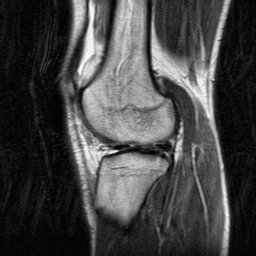

In [21]:
img = mri_vol[slice_number, :, :]
normalized_image_data = (img - img.min()) / (img.max() - img.min())

new_image = normalized_image_data * 255

#Keep only the two first dimensions
new_image = new_image[:, :, 0]

new_image = new_image.astype(np.uint8)
new_image = cv2.cvtColor(new_image, cv2.COLOR_GRAY2RGB)
new_image = cv2.resize(new_image, (256, 256))
new_image = Image.fromarray(new_image)
display(new_image)